# Projectwork

Jacob Thönes

_Based on_:
Fast Direct Solvers for Elliptic PDEs (book), 2019, 
Martinsson, Per-Gunnar
https://doi.org/10.1137/1.9781611976045

# The fast multipole method
The aim is to solve the problem:

$$u_i = \sum_{j=1}^{N} G(x_i,x_j)q_j , \quad i = 1,2,\dots,N .$$

$u_i$ is the evaluated potential, $G$ the kernel functiond and $q_i$ represents $N$ charges. In this case we assume that the positions of sources and evaluated targets are the same.

The kernel is $G(x_i,x_j)$, it represents the uncluttered Laplace-equation. In conclusion we have:

$$G(x,y) = \left\{
\begin{aligned}
log|x-y|,\quad x \neq y\\
0,\quad x = y\\
\end{aligned}
\right.$$

# _Schedule_
-  Generate points
-  The tree of boxes
-  Outgoing and incoming expansions
-  Compute the outgoing expansions
-  Computing the incoming expansions
-  Result

In [1]:
#Import some librarys
using Plots
using LinearAlgebra
using Printf
using Test
using Printf

## 1 Generate points

In [2]:
N = 200; #Number of random points
points = rand(N,2); #Sources/Targets
charge = rand(N); #Charges
chargepos = points[:,1]+im*points[:,2];#The position of the charge. Real part is x, y is the imaginary part.

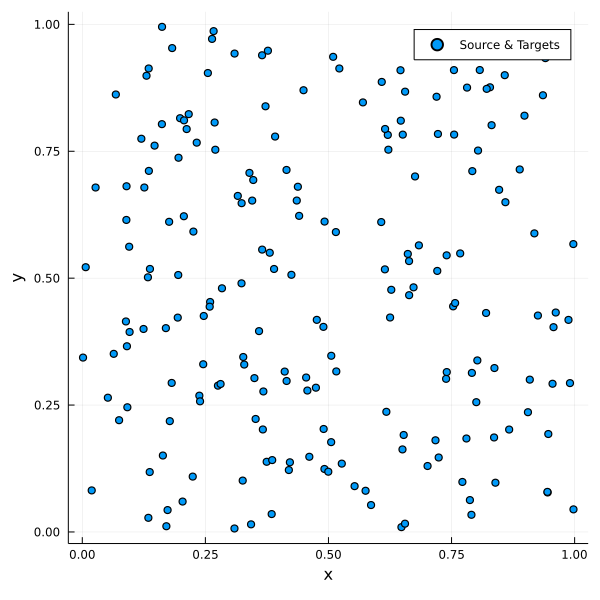

In [3]:
visualise = scatter(points[:,1], points[:,2], label="Source & Targets")
plot(visualise, size = (600,600))
xlabel!("x")
ylabel!("y")

## 2 The tree of boxes

Split the considered square $\Omega$ around the random generated points in $4^L$ equal sized smaller boxes, were the integer $L$ is chosen to be large enough that each box holds only a small number of points. These $4^L$ equal-sized small boxes form the _leaf boxes_ of the tree. We merge the _leaf boxes_ by sets of four to form $4^{L−1}$ boxes of twice the side length, and then continue merging by sets of four until we recover the original box $\Omega$, which forms the _root_ of the _tree_. The set consisting of all boxes of the same size forms a _level_. We label the levels using the integers $l = 0, 1, 2, \dots, L$, with $l = 0$ denoting the root and $l = L$ denoting the leaf boxes.
Given a box $\tau$ in the hierarchical tree, let us next define some index vectors that are referred as a _list_:
- The _parent_ of $\tau$ is the box on the next coarsest level that contains $\tau$.
- The _children_ list of $\tau$  is the set $\cal{L}^{\text{child}}_{\tau}$ of boxes whose parent is $\tau$.
- The _neighbor_ list of $\tau$ is the set $\cal{L}^{\text{nei}}_{\tau}$ of boxes on the same level that directly touch $\tau$
- The _node_ defines every single element in the _tree_

In this case we chose the level $L$ by the following equation:
$$L = \frac{log\left(\frac{Number of points}{Minimum numper per box}\right)}{log(4)} $$
Determine the number of levels $L$, minimum is $2$.

In [4]:
L = floor(log(size(points,1)/3)/log(4));
if L<2
    L=2
end

### 2.1 Determine the boundary box
Next we define the boundary box. The boundarys are given by the min and max coordinates of the generated random points.
The function _boxsize_ detemines depending of the minimum and maximum coordinates the fitted boundary box.

In [5]:
#Define the boundarybox
struct BoxBound
    xmin::Float64
    xmax::Float64
    ymin::Float64
    ymax::Float64
end

In [6]:
function boxsize(points)
    return BoxBound(
        minimum([points[:,1];points[:,2]]), 
        maximum([points[:,1];points[:,2]]), 
        minimum([points[:,1];points[:,2]]), 
        maximum([points[:,1];points[:,2]]))
end

boxsize (generic function with 1 method)

Next we design a struct representing all "Nodes".
This includes the box number, the position in the grid of the
corresponding level, the center coordinate, charge, position of charge,
index, children, neighbourds and interactions. Very important are the vectors from the type struct _Node_ itself.

In [7]:
mutable struct Node
    boxnumber::Int64
    gridnum::ComplexF64
    box::BoxBound
    center::ComplexF64
    charge::Vector{ComplexF64}
    v::Vector{ComplexF64}
    index::Vector{Int64}
    children::Vector{Node}
    neighbour::Vector{Node}
    int::Vector{Node}
end

### 2.2 Parents and their children
To iterate the different levels later we have to create the children of a parent box. This is done through the following function.

In [8]:
function get_childbox(num, pb::BoxBound)#pb=ParentBox
    if num == 1
        return BoxBound(pb.xmin, 
                        pb.xmin + (pb.xmax-pb.xmin)/2, 
                        pb.ymin + (pb.ymax-pb.ymin)/2, 
                        pb.ymax)
    end
    if num == 2
        return BoxBound(pb.xmin + (pb.xmax-pb.xmin)/2, 
                        pb.xmax, 
                        pb.ymin + (pb.ymax-pb.ymin)/2,
                        pb.ymax)
    end
    if num == 3
        return BoxBound(pb.xmin, 
                        pb.xmin + (pb.xmax-pb.xmin)/2, 
                        pb.ymin, 
                        pb.ymin + (pb.ymax-pb.ymin)/2)
    end
    if num == 4
        return BoxBound(pb.xmin + (pb.xmax-pb.xmin)/2, 
                        pb.xmax, 
                        pb.ymin, 
                        pb.ymin + (pb.ymax-pb.ymin)/2)
    end
end

get_childbox (generic function with 1 method)

This function is called in context with _new_Level_. It is called recursive as long as the parent level reaches the maximum level $L$. Inside the struct _Node_ the center and box size data are saved.

In [9]:
function new_level(boxnum, grid, boxsize, L, parentlevel)
    bSiz = boxsize;
    xhold = (real(grid)-1)*2+1;
    yhold = (imag(grid)-1)*2+1;
    if L == parentlevel
        center = bSiz.xmin + (bSiz.xmax-bSiz.xmin)/2 + im*(bSiz.ymin + (bSiz.ymax-bSiz.ymin)/2);
        return Node(boxnum, grid, bSiz, center,[],[],[],[],[],[])
    end
    if L > parentlevel
        bNum = (boxnum-1)*4 + 1;
        center = bSiz.xmin + (bSiz.xmax-bSiz.xmin)/2 + im*(bSiz.ymin + (bSiz.ymax-bSiz.ymin)/2);
        return Node(boxnum,grid, bSiz, center,[],[],[],
                    [new_level(bNum + 1,(xhold + im*(yhold+1)), get_childbox(1,bSiz), L, parentlevel+1);
                     new_level(bNum + 2,(xhold+1 + im*(yhold+1)), get_childbox(2,bSiz), L, parentlevel+1); 
                     new_level(bNum + 3,(xhold + im*(yhold)), get_childbox(3,bSiz), L, parentlevel+1); 
                     new_level(bNum + 4,(xhold+1 + im*(yhold)), get_childbox(4,bSiz), L, parentlevel+1)],[],[]) 
    end
end

new_level (generic function with 1 method)

### 2.3 Insert generated charges into the tree
Now it is possible to sort all random generated points into the boxes. This sorting happens with a comparison of the center of all boxes with the $x$- and $y$-position of the generated charges.

In [10]:
function insert_charges(x::Float64, y::Float64,index::Int64, charge::Float64, MyTree::Node)
    MyTree.index = [MyTree.index; index]
    if !isempty(MyTree.children)  
        if x > real(MyTree.center)
            if y>imag(MyTree.center)
                insert_charges(x,y,index,charge,MyTree.children[2])
            else
                insert_charges(x,y,index,charge,MyTree.children[4])
            end
        else
            if y>imag(MyTree.center)
                insert_charges(x,y,index,charge,MyTree.children[1])
            else
                insert_charges(x,y,index,charge,MyTree.children[3])
            end
        end
    end
end

insert_charges (generic function with 1 method)

## 3 Outgoing and incoming expansions
(Martinsson: site 69)

The _outgoing expansion_ is a compact representation of the field generated by all the sources that are contained in the box. The _incoming expansion_ is a compact representation of the potential in the box that is generated by all sources that are well separated from the box. These vectors are of length $P$, where $P$ is a tuning parameter that trades computational cost for accuracy. For a fixed _expansion order_ $P$, we define these expansions in the tree as follows:

- The _outgoing expansion_ $\hat{\textbf{q}}_{\tau} \in \mathbb{C}^P$

- The _incoming expansion_ $\hat{\textbf{u}}_{\tau} \in \mathbb{C}^P$

This field is analytic around the center $c_{\tau}$ of $\Omega_{\tau}$, and the _incoming expansion_ vector $\hat{\textbf{u}}_{\tau}$ holds the first $P$ coefficients in the Taylor series for $u_{\tau}$ around $c_{\tau}$.
All boxes that are not _well seperated_ are called _neighbours_. Their edges are directly in contact with the considered box.

#### Get the neighbours

In [11]:
function get_the_neighbours(Tree::Node, boxlevels)
    neighbour = [];
    neighbourChildren = [];
    interactions = [];
    x = real(Tree.gridnum)
    y = imag(Tree.gridnum)
    if Tree.boxnumber>1 
        for nodes in boxlevels
            if abs(real(nodes.gridnum)-x) <= 1 && abs(imag(nodes.gridnum)-y) <= 1 && abs(imag(nodes.gridnum)-y)+abs(real(nodes.gridnum)-x)!=0
                neighbour = [neighbour; nodes];
                if nodes.children!=[]
                    neighbourChildren = [neighbourChildren; nodes.children[1]; nodes.children[2]; nodes.children[3]; nodes.children[4]]
                end
            else
                if abs(imag(nodes.gridnum)-y)+abs(real(nodes.gridnum)-x)!=0
                    interactions = [interactions; nodes]
                end
            end
        end
        Tree.neighbour = neighbour;
        Tree.int = interactions;
        if Tree.children!=[]
            for Child in Tree.children
                get_the_neighbours(Child, [neighbourChildren; Tree.children]);
            end
        end
    else
        box = []
        for boxes in boxlevels
            box = [box; boxes.children]
        end
        for Child in Tree.children
            get_the_neighbours(Child, box);
        end
    end
end

get_the_neighbours (generic function with 1 method)

#### The upward pass
The upwards pass describes the _outgoing expansion_ for every box. The charges inside one box will be substituated as a single charge in the center of the box. For a box that has children, the outgoing expansion is computed not directly from the sources located in the box but from the outgoing expansions of its children. This is why it is called the _upward pass_.

#### The downward pass
In the downwards pass, the incoming expansion is computed
for every box. This is done by converting the outgoing expansions constructed in the
upwards pass to incoming expansions.

## 4 Compute the outgoing expansions

### 4.1 Outgoing from source
As our first task, for each box $\tau$ in the tree we will build its _outgoing expansion_ $\hat{\textbf{q}}_{\tau}$. Let $I_{\tau}$ denote a list of all the points $x_j$ such that $x_j \in \Omega_{\tau}$. We start by processing with the lowest level on the smallest boxes. So we compute the expasions outgoing from the source points:

$$ \begin{cases}
\hat q_0^{\tau} = \sum_{j \epsilon I_{\tau}} q_j \\
\hat q_p^{\tau} = \sum_{j \epsilon I_{\tau}} -\frac{1}{p} \big(x_j - c_{\tau} \big)^p q_j , & p=1,2,\dots , P-1 
\end{cases}$$

Reminder: $P$ is the expansion order.

In [12]:
function outgoing_from_source(Tree::Node, P)
    if isempty(Tree.children)
        Tree.charge = zeros(ComplexF64, P)
        for index in Tree.index
            Tree.charge[1] += charge[index]
        end
        for index in Tree.index
            R = chargepos[index]-Tree.center
            for p = 1:(P - 1)
                Tree.charge[p+1] += (-1.0/p)*R^p*charge[index]
            end
        end
    else
        for i = 1:length(Tree.children)
            outgoing_from_source(Tree.children[i], P);
        end
    end
end

outgoing_from_source (generic function with 1 method)

### 4.2 Outgoing from outgoing
(Martinsson: side 71)

The _outgoing-from-outgoing translation operator_ $\textbf{T}_{\tau,\sigma}^\text{ofo}$ is called such as:

$$\begin{cases}
\hat q_0^{\tau} = \hat q_0^{\sigma}\\
\hat q_p^{\tau} = -\hat q_0^{\sigma} \frac{1}{p} (c_\sigma-c_\tau)\sum_{j=1}^{p} \hat q_j^{\sigma} {p-1\choose j-1}(c_\sigma-c_\tau)^{p-j}
\end{cases}$$

This calculation runs from the leafs up to the root for all well seperated boxes. It means that the first and the second level are not used, because the well seperated boxes are missing.

In [13]:
function outgoing_from_outgoing(Tree::Node, P)
    if isempty(Tree.charge)
        for i = 1:length(Tree.children)
            outgoing_from_outgoing(Tree.children[i], P)
        end
        Tree.charge = zeros(ComplexF64, P)
        for i = 1:length(Tree.children)
            Tree.charge[1] += Tree.children[i].charge[1]
            for m = 1:P-1
                Tree.charge[m+1] += -1/m*(Tree.children[i].center-Tree.center)^m*Tree.children[i].charge[1]
            end
            for n = 1:P-1
                for s = 1:n
                    Tree.charge[n+1] += binomial(n-1,s-1)*(Tree.children[i].center-Tree.center)^(n-s)*Tree.children[i].charge[s+1]
                end
            end
        end
    end
end

outgoing_from_outgoing (generic function with 1 method)

## 5. Computing the incoming expansions

### 5.1 Incoming from outgoing
(Martinsson: side 71)

The incoming expansions for all boxes are built in a top-down sweep through the tree of boxes, going from largest to smallest. All boxes at levels $l = 0$ and $l = 1$ have zero incoming expansions, so the first nontrivial ones arise at level $l = 2$. 
Let $\tau$ be a box on level $2$, then all sources that contribute to the incoming expansion for $\tau$ belong to boxes in the interaction list of $\tau$. We can therefore easily build the incoming expansion for $\tau$ by exploiting the outgoing expansions for all of these well seperated boxes, so

$$\hat{\textbf{u}}_{\tau} = \sum_{\sigma \in \cal{L}_{\tau}} \textbf{T}^{\text{ifo}}_{\tau, \sigma} \hat{\textbf{q}}_{\sigma}$$.

The final equation to calculate the expansion is defined as:

$$\begin{cases}
\hat v_0^{\tau} = \hat q_0^{\sigma}log(c_\tau-c_\sigma)+\sum_{p=1}^{\infty} \hat q_p^{\sigma} (-1)^p \frac {1}{(c_\sigma-c_\tau)^p}\\
\hat v_r^{\tau} = \hat -q_0^{\sigma}\frac {1}{(c_\tau-c_\sigma)}+\sum_{p=1}^{\infty} \hat q_p^{\sigma} (-1)^p {r+p-1\choose p-1} \frac {1}{(c_\sigma-c_\tau)^{r+p}}
\end{cases}$$

In [14]:
function incoming_from_outgoing(Tree::Node, P)
    if isempty(Tree.int)
        for i = 1:length(Tree.children)
            incoming_from_outgoing(Tree.children[i], P)
        end
    else
        Tree.v = zeros(ComplexF64,P)
        for i=1:length(Tree.int)
            R = Tree.int[i].center - Tree.center
            Tree.v[0 + 1] += Tree.int[i].charge[0 + 1] * log(-R)
            for p = 1:(P - 1)
                Tree.v[0 + 1] += Tree.int[i].charge[p + 1] * (-1)^(p) * 1/R^p
            end
            for r = 1:(P - 1)
                Tree.v[r + 1] += -Tree.int[i].charge[0 + 1]/(r*R^r)
                for p = 1:(P - 1)
                    Tree.v[r + 1] += Tree.int[i].charge[p + 1]*(-1.0)^(p) * binomial(r + p - 1, p - 1)/R^(r + p)
                end
            end
        end
        if !isempty(Tree.children)
            for Child in Tree.children
                incoming_from_outgoing(Child, P)
            end
        end
    end
end

incoming_from_outgoing (generic function with 1 method)

### 5.2 Incoming from incoming
(Martinsson: side 73)

The _incoming from incoming_ expansion is a compact representation of the potential in the box that is generated by the parent boxes. The _incoming from outgoing_ expansions just represented all well seperated influences. The equation that describes this expansion is:

$$\textbf{T}_{\sigma, \tau}^\text{ifi} (r,p) = \begin{cases}
{p\choose r} (c_{\sigma} - c_{\tau})^{p-r} \quad & \text{for } r\leq p,\\
0 & \text{for } r > p
\end{cases}$$

$$\hat{\textbf{u}}_{\tau} = \textbf{T}^{\text{ifi}}_{\tau, \sigma} \hat{\textbf{u}}_{\sigma}$$.


In [15]:
function incoming_from_incoming(Tree::Node, parCenter, parIncoming::Vector{ComplexF64})
    if !isempty(Tree.children)
        for i=1:length(Tree.children)
            incoming_from_incoming(Tree.children[i],Tree.center, Tree.v)
        end
    end
    for r = 0:length(Tree.charge)-1
        for p = r:length(Tree.charge)-1
            Tree.v[r+1] += binomial(p,r)*(Tree.center-parCenter)^(p-r)*parIncoming[p+1]
        end
    end
end

function run_incoming_from_incoming(Tree::Node)
    if isempty(Tree.int)
        for child in Tree.children
            run_incoming_from_incoming(child)
        end
    else
        for i=1:length(Tree.children)
            incoming_from_incoming(Tree.children[i],Tree.center, Tree.v)
        end
    end
end

run_incoming_from_incoming (generic function with 1 method)

### 5.3 Incoming expansion

The _incoming expansion_ is located at the center of a box and consists the sum of the _incoming from outgoing_ and the _incoming_ expansion from the 3rd level. The potential at the target points is calculated according to the equation:

$$ u(x) = \sum_{p=0}^{\infty} (x-c_{\tau})^p \hat v_p^{\tau}$$

In [16]:
function incoming_expansion(Tree::Node)
    if !isempty(Tree.children)
        for child in Tree.children
            incoming_expansion(child)
        end
    else
        for index in Tree.index
            x = chargepos[index]
            for p = 0:length(Tree.v)-1
                u[index] += (x-Tree.center)^p * Tree.v[p+1]
            end 
        end
    end
end

incoming_expansion (generic function with 1 method)

### 5.4 Nearest interactions

The last step is to calculate the interactions of all charges in a box and corresponding leaf boxes. This is possible with the following equation. 
$$u_i = log(||x-c||)q_i $$

In [17]:
function nearest_interactions(Tree::Node)
    if isempty(Tree.children)
        for index in Tree.index
            tau = chargepos[index]
            for neighbour in Tree.neighbour
                for neighbour_index in neighbour.index
                    sigma = chargepos[neighbour_index]
                    norm_τσ = norm(tau-sigma)
                    if norm_τσ > eps()*10/norm(tau+sigma)
                        u[index] += log(norm_τσ)*charge[neighbour_index]
                    end
                end
            end
            for box_index in Tree.index
                sigma = chargepos[box_index]
                norm_τσ = norm(tau-sigma)
                if norm_τσ > eps()*10/norm(tau+sigma)
                    u[index] += log(norm_τσ)*charge[box_index]
                end
            end
        end
    else
        for child in Tree.children
            nearest_interactions(child)
        end
    end 
end

nearest_interactions (generic function with 1 method)

## 6 Result

### 6.1 Direct solution

In [18]:
#Credit: Jun.-Prof. Dr.-Ing. Simon Adrian, Universität Rostock 2021.

function G(τ,σ)
    norm_τσ = norm(τ-σ)
    if norm_τσ > eps()*10/norm(τ+σ)
        return log(norm_τσ)
    else
        return zero(typeof(norm_τσ))
    end
end

function get_full_systemmatrix(opoints, spoints, N_max)
    N_o = size(opoints, 1)
    N_s = size(spoints, 1)

    if N_s <= N_max && N_o <= N_max 
        𝗚 = zeros(ComplexF64,N_o,N_s)

        for t=1:N_o
            for s=1:N_s
                𝗚[t,s] = G(opoints[t,:],spoints[s,:])
            end
        end
    end
    return 𝗚
end

get_full_systemmatrix (generic function with 1 method)

### 6.2 Convergence of the error

To determine the accuracy depending to the expansion oder $P$ this parameter is scaled from one up to 30.
Inside the for-loop everytime the completely FMM and the direct solution is computed. At the end of the for-loop the accuracy is  determined between the exact solution and the result of the FMM.

In [19]:
accuracy = []
u = zeros(ComplexF64, length(charge));
for P = 1:30        
    u = zeros(ComplexF64, length(charge));
    
    box = boxsize(points)
    MyTree = new_level(1,1+im*1, box, L, 0);
    for i = 1:length(chargepos)
        insert_charges(real(chargepos[i]), imag(chargepos[i]),i ,charge[i], MyTree)
    end
    get_the_neighbours(MyTree,[MyTree]);
    outgoing_from_source(MyTree, P);
    outgoing_from_outgoing(MyTree, P);
    incoming_from_outgoing(MyTree,P);
    run_incoming_from_incoming(MyTree);
    incoming_expansion(MyTree);
    nearest_interactions(MyTree);
    
    𝗚 = get_full_systemmatrix(points, points, 10000);
    v_exact = 𝗚*charge;
    accuracy = [accuracy; norm(real(u)-v_exact)/norm(v_exact)]   
end

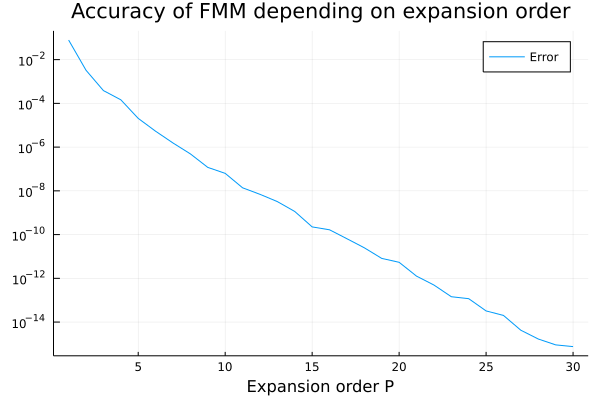

In [20]:
plot(1:30,accuracy,yaxis=:log ,label="Error",xaxis="Expansion order P",title="Accuracy of FMM depending on expansion order")

### 6.3 Comparison of FMM and the direct solution

In [21]:
ges_timeFMM = []
N_vec = []
for N = 1000:100:5000
    N_vec = [N_vec; N]
    #N=Number of random points
    points = rand(N,2); #Sources/Targets
    charge = rand(N); #Charges
    chargepos = points[:,1]+im*points[:,2];#The position of the charge. Real part is x, y is the imaginary part.
    P=5 #Expansion order
    level = floor(log(size(points,1)/5)/log(4));
    if level<2
        level=2
    end
    u = zeros(ComplexF64, length(charge));
    box = boxsize(points)
    MyTree = new_level(1,1+im*1, box, level, 0);
    for i = 1:length(chargepos)
        insert_charges(real(chargepos[i]), imag(chargepos[i]),i ,charge[i], MyTree)
    end
    get_the_neighbours(MyTree,[MyTree]);

    timeFMM = @elapsed outgoing_from_source(MyTree, P);
    timeFMM += @elapsed outgoing_from_outgoing(MyTree, P);
    timeFMM += @elapsed incoming_from_outgoing(MyTree,P);
    timeFMM += @elapsed run_incoming_from_incoming(MyTree);
    timeFMM += @elapsed incoming_expansion(MyTree);
    timeFMM += @elapsed nearest_interactions(MyTree);
    ges_timeFMM = [ges_timeFMM; timeFMM];
    timeFMM = 0;
end

In [22]:
ges_timeDIR = []
N_vec = []
N=0
for N = 1000:100:5000
    N_vec = [N_vec; N]#N=Number of random points
    points = rand(N,2); #Sources/Targets
    charge = rand(N); #Charges
    timeDirect = @elapsed 𝗚 = get_full_systemmatrix(points, points, N);
    timeDirect += @elapsed 𝗚*charge;
    ges_timeDIR = [ges_timeDIR; timeDirect]
    timeDirect = 0;
end

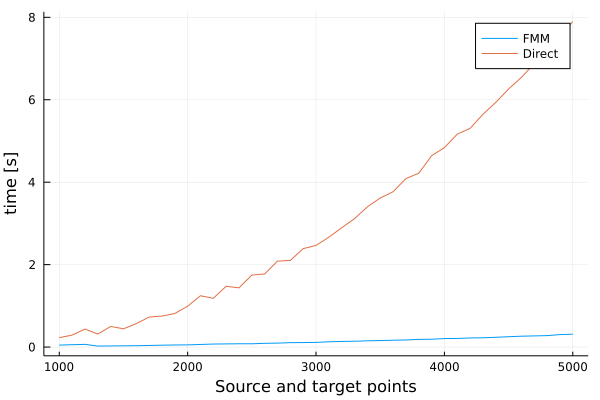

In [23]:
plot(N_vec, ges_timeFMM,xaxis="Source and target points", yaxis = "time [s]", label="FMM")
plot!(N_vec, ges_timeDIR, label="Direct")

It is really obvious that the speed of the FMM is much better than the calculation time of the direct solution. Especially for big problems the FMM is much faster.